The prototypical example of Bayesian nonparametrics in practice is the Dirichlet Process Mixture Model (DPMM)


A DPMM allows for a practitioner to build a mixture model when the number of distinct clusters in the geometric structure of their data is unknown – in other words, the number of clusters is allowed to grow as more data is observed. 

This feature makes the DPMM highly useful towards exploratory data analysis, where few facets of the data in question are known; this presentation aims to demonstrate this fact.

In [205]:
import sys
!{sys.executable} -m pip install pandas_datareader


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)

import os

os.environ['KMP_DUPLICATE_LIB_OK'] ='True'

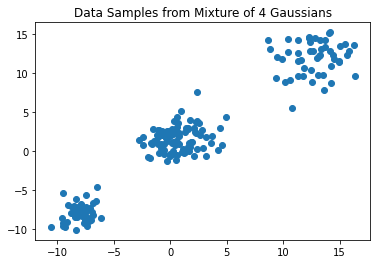

In [206]:
data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(12 * torch.ones(2), 5 * torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), 2 * torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))
#print(torch.eye(2))
#print(torch.tensor([1.5, 2]))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0] # number of samples 

First, let’s define the “stick-breaking” function that generates our weights, given our samples of $\beta$

The premise of this is that we are looking for ways to break that stick of total size 1 into portions that accurately reflect the mixing contributions of each Gaussian in our GMM. 

In [207]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1) # beta distribution prior
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [208]:
# T - 1 conditionally independent beta distributions, because you can determine 
# the final one via the stick breaking paradigm since it adds up to 1

# T independent mu's for a potential of T different clusters

# N cluster identifications for the total number of data points
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha)) # beta distribution prior for stick breaking process

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 8 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

In [209]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex) #stick

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

100%|██████████| 1000/1000 [00:10<00:00, 98.27it/s]


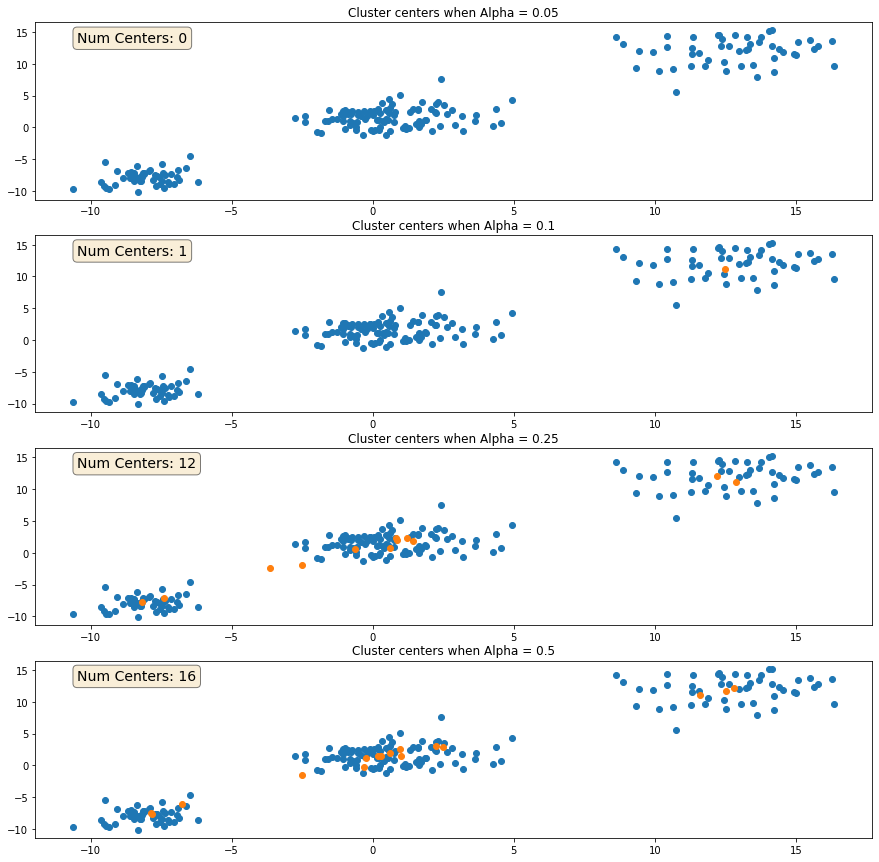

In [210]:
T = 16 #maximum number of clusters 
optim = Adam({"lr": 0.05})

# inference
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for _ in tqdm(range(num_iterations)): 
        losses.append(svi.step(data))

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights


alpha = 0.05
train(1000)
Bayes_Centers_002, Bayes_Weights_002 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))


alpha = 0.1
train(1000)
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 0.25
train(1000)
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))


alpha = 0.5
train(1000)
Bayes_Centers_50, Bayes_Weights_50 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

fig, axs = plt.subplots(4)
fig.set_figheight(15)
fig.set_figwidth(15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

axs[0].text(0.05, 0.95, "Num Centers: " + str(len(Bayes_Centers_002)), transform=axs[0].transAxes,  fontsize=14, verticalalignment='top', bbox=props)
axs[0].title.set_text('Cluster centers when Alpha = 0.05')
axs[0].scatter(data[:, 0], data[:, 1])
axs[0].scatter(Bayes_Centers_002[:, 0], Bayes_Centers_002[:, 1])

axs[1].text(0.05, 0.95, "Num Centers: " + str(len(Bayes_Centers_01)), transform=axs[1].transAxes,  fontsize=14, verticalalignment='top', bbox=props)
axs[1].title.set_text('Cluster centers when Alpha = 0.1')
axs[1].scatter(data[:, 0], data[:, 1])
axs[1].scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1])

axs[2].text(0.05, 0.95, "Num Centers: " + str(len(Bayes_Centers_15)), transform=axs[2].transAxes,  fontsize=14, verticalalignment='top', bbox=props)
axs[2].title.set_text('Cluster centers when Alpha = 0.25')
axs[2].scatter(data[:, 0], data[:, 1])
axs[2].scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1])

axs[3].text(0.05, 0.95, "Num Centers: " + str(len(Bayes_Centers_50)), transform=axs[3].transAxes,  fontsize=14, verticalalignment='top', bbox=props)
axs[3].title.set_text('Cluster centers when Alpha = 0.5')
axs[3].scatter(data[:, 0], data[:, 1])
axs[3].scatter(Bayes_Centers_50[:, 0], Bayes_Centers_50[:, 1])

100%|██████████| 1000/1000 [00:10<00:00, 96.41it/s]


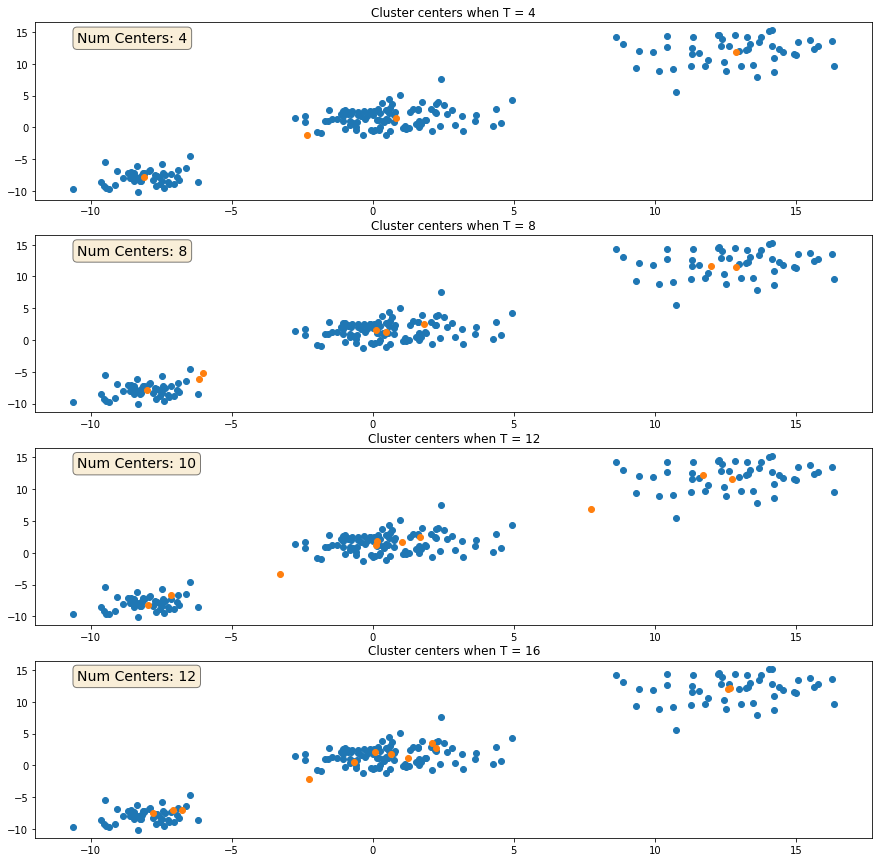

In [211]:
alpha = 0.25

T = 4
train(1000)
Bayes_Centers_002, Bayes_Weights_002 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))


T = 8
train(1000)
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

T = 12
train(1000)
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))


T = 16
train(1000)
Bayes_Centers_50, Bayes_Weights_50 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))



fig, axs = plt.subplots(4)
fig.set_figheight(15)
fig.set_figwidth(15)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

axs[0].text(0.05, 0.95, "Num Centers: " + str(len(Bayes_Centers_002)), transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
axs[0].title.set_text('Cluster centers when T = 4')
axs[0].scatter(data[:, 0], data[:, 1])
axs[0].scatter(Bayes_Centers_002[:, 0], Bayes_Centers_002[:, 1])

axs[1].text(0.05, 0.95, "Num Centers: " + str(len(Bayes_Centers_01)), transform=axs[1].transAxes,  fontsize=14, verticalalignment='top', bbox=props)
axs[1].title.set_text('Cluster centers when T = 8')
axs[1].scatter(data[:, 0], data[:, 1])
axs[1].scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1])

axs[2].text(0.05, 0.95, "Num Centers: " + str(len(Bayes_Centers_15)), transform=axs[2].transAxes, fontsize=14, verticalalignment='top', bbox=props)
axs[2].title.set_text('Cluster centers when T = 12')
axs[2].scatter(data[:, 0], data[:, 1])
axs[2].scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1])

axs[3].text(0.05, 0.95, "Num Centers: " + str(len(Bayes_Centers_50)), transform=axs[3].transAxes,  fontsize=14, verticalalignment='top', bbox=props)
axs[3].title.set_text('Cluster centers when T = 16')
axs[3].scatter(data[:, 0], data[:, 1])
axs[3].scatter(Bayes_Centers_50[:, 0], Bayes_Centers_50[:, 1])

Using real data:

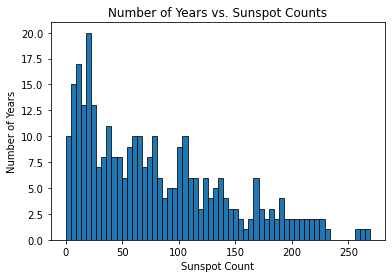

In [215]:
df = pd.read_csv('http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32).round()
N = data.shape[0]

plt.hist(df['sunspot.year'].values, bins=60, edgecolor='black', linewidth=0.75)
plt.title("Number of Years vs. Sunspot Counts")
plt.xlabel("Sunspot Count")
plt.ylabel("Number of Years")
plt.show()

100%|██████████| 1500/1500 [00:06<00:00, 232.34it/s]


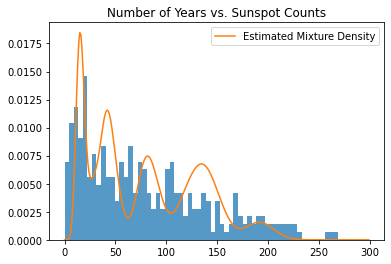

100%|██████████| 1500/1500 [00:06<00:00, 244.53it/s]


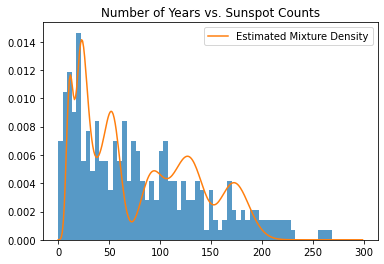

100%|██████████| 1500/1500 [00:06<00:00, 243.92it/s]


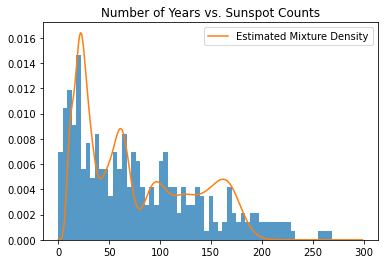

In [220]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("lambda_plate", T):
        lmbda = pyro.sample("lambda", Gamma(3, 0.05))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", Poisson(lmbda[z]), obs=data)

def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau_0 = pyro.param('tau_0', lambda: Uniform(0, 5).sample([T]), constraint=constraints.positive)
    tau_1 = pyro.param('tau_1', lambda: LogNormal(-1, 1).sample([T]), constraint=constraints.positive)
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("lambda_plate", T):
        q_lambda = pyro.sample("lambda", Gamma(tau_0, tau_1))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

T = 20
alpha = 0.05
n_iter = 1500
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

train(n_iter)

samples = torch.arange(0, 300).type(torch.float)

tau0_optimal = pyro.param("tau_0").detach()
tau1_optimal = pyro.param("tau_1").detach()
kappa_optimal = pyro.param("kappa").detach()

# We make a point-estimate of our latent variables using the posterior means of tau and kappa for the cluster params and weights
Bayes_Rates = (tau0_optimal / tau1_optimal)
Bayes_Weights = mix_weights(1. / (1. + kappa_optimal))

def mixture_of_poisson(weights, rates, samples):
    return (weights * Poisson(rates).log_prob(samples.unsqueeze(-1)).exp()).sum(-1)

likelihood = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.title("Number of Years vs. Sunspot Counts")
plt.hist(data, bins=60, density=True, lw=0, alpha=0.75);
plt.plot(samples, likelihood, label="Estimated Mixture Density")
plt.legend()
plt.show()

alpha = 0.1
train(n_iter)

samples = torch.arange(0, 300).type(torch.float)

tau0_optimal = pyro.param("tau_0").detach()
tau1_optimal = pyro.param("tau_1").detach()
kappa_optimal = pyro.param("kappa").detach()

Bayes_Rates = (tau0_optimal / tau1_optimal)
Bayes_Weights = mix_weights(1. / (1. + kappa_optimal))

likelihood = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.title("Number of Years vs. Sunspot Counts")
plt.hist(data, bins=60, density=True, lw=0, alpha=0.75);
plt.plot(samples, likelihood, label="Estimated Mixture Density")
plt.legend()
plt.show()


alpha = 0.25
train(n_iter)

samples = torch.arange(0, 300).type(torch.float)

tau0_optimal = pyro.param("tau_0").detach()
tau1_optimal = pyro.param("tau_1").detach()
kappa_optimal = pyro.param("kappa").detach()

Bayes_Rates = (tau0_optimal / tau1_optimal)
Bayes_Weights = mix_weights(1. / (1. + kappa_optimal))

likelihood = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.title("Number of Years vs. Sunspot Counts")
plt.hist(data, bins=60, density=True, lw=0, alpha=0.75);
plt.plot(samples, likelihood, label="Estimated Mixture Density")
plt.legend()
plt.show()

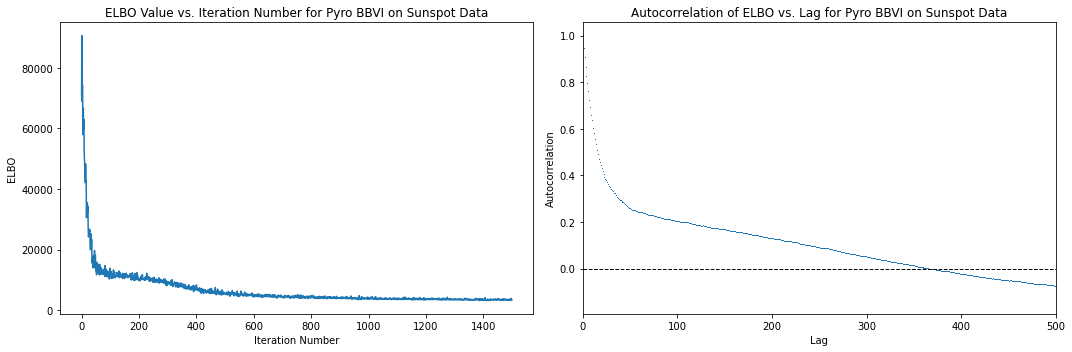

In [222]:
elbo_plot = plt.figure(figsize=(15, 5))

elbo_ax = elbo_plot.add_subplot(1, 2, 1)
elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI on Sunspot Data")
elbo_ax.set_ylabel("ELBO")
elbo_ax.set_xlabel("Iteration Number")
elbo_ax.plot(np.arange(n_iter), losses[:1500])

autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
autocorr_ax.acorr(np.asarray(losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
autocorr_ax.set_xlim(0, 500)
autocorr_ax.axhline(0, ls="--", c="k", lw=1)
autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI on Sunspot Data")
autocorr_ax.set_xlabel("Lag")
autocorr_ax.set_ylabel("Autocorrelation")
elbo_plot.tight_layout()
plt.show()
